## 트랜스포머 개념

Transformer 기본 구조 - encoder

- 트랜스포머는 n개의 인코더 층을 쌓는 데 이 때 n은 하이퍼파라미터로서 인코더층과 디코더층의 개수를 의미
- 인코더층은 크게 총 2개의 sublayer로 구성
  - self-attention, feed-forward neural network
  
#### 1. self-attention

- 각 input으로부터 3개의 벡터인 q, k, v를 만듦
- 특정 단어와 문장에 사용된 모든 단어와의 점수(연관성) 계산

https://medium.com/platfarm/%EC%96%B4%ED%85%90%EC%85%98-%EB%A9%94%EC%BB%A4%EB%8B%88%EC%A6%98%EA%B3%BC-transfomer-self-attention-842498fd3225

#### 2. positional encoding
 - 예를 들어 I love you but not love him이라는 문장이라면 앞의 love와 뒤의 love은 일반적인 임베딩만을 거쳤을 때 동일한 값을 가지게 됨(Word2Vec과 같은 임베딩의 문제) 하지만 Positional Encoding 이라는 주기함수에 의한 위치에 따른 다른 임베딩을 거치면 같은 단어여도 문장에서 쓰인 위치에 따라 다른 임베딩 값을 가지게 됨
 
 
 - Encoder
  - EncoderLayer
    - MultiHeadAttention
      - ScaleDotProductAttention

## 트랜스포머 규격

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [6]:
class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.projection = nn.Linear(d_model, tgt_vocab_size, bias=False)
    def forward(self, enc_inputs, dec_inputs):
        enc_outputs, enc_self_attns = self.encoder(enc_inputs)
        dec_outputs, dec_self_attns, dec_enc_attns = self.decoder(dec_inputs, enc_inputs, enc_outputs)
        dec_logits = self.projection(dec_outputs) # dec_logits : [batch_size x src_vocab_size x tgt_vocab_size] #  활성화 함수가 존재하지 않으며 룩업 테이블이라는 연산을 담당하는 층으로 일반적인 은닉층과 구분하기 위해 투사층(projection layer)이라고 부름
        return dec_logits.view(-1, dec_logits.size(-1)), enc_self_attns, dec_self_attns, dec_enc_attns

## 인코더부

In [7]:
def make_batch(sentences):
    input_batch = [[src_vocab[n] for n in sentences[0].split()]] # input 문장을 단어로 분리 후 워드 임베딩
    output_batch = [[tgt_vocab[n] for n in sentences[1].split()]] # output 문장을 단어로 분리 후 워드 임베딩
    target_batch = [[tgt_vocab[n] for n in sentences[2].split()]] 
    return torch.LongTensor(input_batch), torch.LongTensor(output_batch), torch.LongTensor(target_batch)

In [8]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.src_emb = nn.Embedding(src_vocab_size, d_model) # 임베딩 차원 초기화
        self.pos_emb = nn.Embedding.from_pretrained(get_sinusoid_encoding_table(src_len+1, d_model),freeze=True) # Positional Encoding
        self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)]) # Encoder Layer

    def forward(self, enc_inputs): # enc_inputs : [batch_size x source_len]
        enc_outputs = self.src_emb(enc_inputs) + self.pos_emb(torch.LongTensor([[1,2,3,4,0]]))
        print(enc_inputs)
        enc_self_attn_mask = get_attn_pad_mask(enc_inputs, enc_inputs)
        enc_self_attns = []
        for layer in self.layers:
            enc_outputs, enc_self_attn = layer(enc_outputs, enc_self_attn_mask) # 단어 to 임베딩(enc_outputs)을 EncoderLayer에 전달
            enc_self_attns.append(enc_self_attn)
        return enc_outputs, enc_self_attns

In [9]:
# for sequence order
# 이 값이 동일하게 매 Layer마다 Q, K, V로 복사되어 Encoder_Layer로 들어가 MultiHeadAttention를 거치게 됨
def get_sinusoid_encoding_table(n_position, d_model):
    def cal_angle(position, hid_idx):
        return position / np.power(10000, 2 * (hid_idx // 2) / d_model)
    def get_posi_angle_vec(position):
        return [cal_angle(position, hid_j) for hid_j in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(n_position)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1
    return torch.FloatTensor(sinusoid_table)

In [10]:
class EncoderLayer(nn.Module):
    def __init__(self):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention() # Self-Attention
        self.pos_ffn = PoswiseFeedForwardNet() # Feed Forward

    def forward(self, enc_inputs, enc_self_attn_mask):
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # enc_inputs to same Q,K,V
        enc_outputs = self.pos_ffn(enc_outputs) # enc_outputs: [batch_size x len_q x d_model]
        return enc_outputs, attn

In [11]:
class MultiHeadAttention(nn.Module):
    def __init__(self):
        super(MultiHeadAttention, self).__init__()
        self.W_Q = nn.Linear(d_model, d_k * n_heads) # Q Linear Transformation, input : 512 , output : 64 * 8(=512)
        self.W_K = nn.Linear(d_model, d_k * n_heads) # K Linear Transformation
        self.W_V = nn.Linear(d_model, d_v * n_heads) # V Linear Transformation
        self.linear = nn.Linear(n_heads * d_v, d_model) # 전이 층
        self.layer_norm = nn.LayerNorm(d_model) # Normalize 층 

    def forward(self, Q, K, V, attn_mask): # enc_outputs, enc_outputs, enc_outputs, enc_self_attn_mask
        # q: [batch_size x len_q x d_model], k: [batch_size x len_k x d_model], v: [batch_size x len_k x d_model]
        residual, batch_size = Q, Q.size(0)
        # (B, S, D) -proj-> (B, S, D) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        q_s = self.W_Q(Q).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # q_s: [batch_size x n_heads x len_q x d_k]
        k_s = self.W_K(K).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # k_s: [batch_size x n_heads x len_k x d_k]
        v_s = self.W_V(V).view(batch_size, -1, n_heads, d_v).transpose(1,2)  # v_s: [batch_size x n_heads x len_k x d_v]
        # Multi Head수 만큼 mask를 복제
        attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1) # attn_mask : [batch_size x n_heads x len_q x len_k]. 

        # context: [batch_size x n_heads x len_q x d_v], attn: [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        context, attn = ScaledDotProductAttention()(q_s, k_s, v_s, attn_mask)
        # multi head dimension 을 원래의 형태로 되돌린다. contiguous 
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_heads * d_v) # context: [batch_size x len_q x n_heads * d_v]
        output = self.linear(context)
        return self.layer_norm(output + residual), attn # output: [batch_size x len_q x d_model]

In [12]:
# 'ich mochte ein bier P' : padding mask
def get_attn_pad_mask(seq_q, seq_k): # 
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # eq(zero) is PAD token
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)  # batch_size x 1 x len_k(=len_q), one is masking
    return pad_attn_mask.expand(batch_size, len_q, len_k)  # batch_size x len_q x len_k

In [13]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()

    def forward(self, Q, K, V, attn_mask):
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k) # scores : [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        scores.masked_fill_(attn_mask, -1e9) # Fills elements of self tensor with value where mask is one.
        attn = nn.Softmax(dim=-1)(scores) # 스코어값을 0~1 양수로 만듬, 얼마나 각 단어들의 표현이 들어갈지 결정?
        context = torch.matmul(attn, V) # 가장 관련있는 단어만 필터링하는 역할
        return context, attn

## FFN

In [14]:
# Position-wise Feed-Forward Networks
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self):
        super(PoswiseFeedForwardNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, inputs):
        residual = inputs # inputs : [batch_size, len_q, d_model]
        output = nn.ReLU()(self.conv1(inputs.transpose(1, 2)))
        output = self.conv2(output).transpose(1, 2)
        return self.layer_norm(output + residual)

## 디코더부

In [15]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.tgt_emb = nn.Embedding(tgt_vocab_size, d_model)
        self.pos_emb = nn.Embedding.from_pretrained(get_sinusoid_encoding_table(tgt_len+1, d_model),freeze=True)
        self.layers = nn.ModuleList([DecoderLayer() for _ in range(n_layers)])

    def forward(self, dec_inputs, enc_inputs, enc_outputs): # dec_inputs : [batch_size x target_len]
        dec_outputs = self.tgt_emb(dec_inputs) + self.pos_emb(torch.LongTensor([[5,1,2,3,4]]))
        # 디코더부 마스크
        dec_self_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs) # padding mask
        dec_self_attn_subsequent_mask = get_attn_subsequent_mask(dec_inputs) # look-ahead mask
        dec_self_attn_mask = torch.gt((dec_self_attn_pad_mask + dec_self_attn_subsequent_mask), 0) # 0보다 클 경우 true로 표기. 그외는 false
        # 인코더부 마스크 (이전과 동일)
        dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs)

        dec_self_attns, dec_enc_attns = [], []
        for layer in self.layers:
            dec_outputs, dec_self_attn, dec_enc_attn = layer(dec_outputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)
            dec_self_attns.append(dec_self_attn)
            dec_enc_attns.append(dec_enc_attn)
        return dec_outputs, dec_self_attns, dec_enc_attns

In [16]:
# look-ahead mask
def get_attn_subsequent_mask(seq):
    attn_shape = [seq.size(0), seq.size(1), seq.size(1)]
    subsequent_mask = np.triu(np.ones(attn_shape), k=1)
    subsequent_mask = torch.from_numpy(subsequent_mask).byte()
    return subsequent_mask

In [19]:
class DecoderLayer(nn.Module):
    def __init__(self):
        super(DecoderLayer, self).__init__()
        self.dec_self_attn = MultiHeadAttention()
        self.dec_enc_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, dec_inputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask):
        dec_outputs, dec_self_attn = self.dec_self_attn(dec_inputs, dec_inputs, dec_inputs, dec_self_attn_mask)
        dec_outputs, dec_enc_attn = self.dec_enc_attn(dec_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)
        dec_outputs = self.pos_ffn(dec_outputs)
        return dec_outputs, dec_self_attn, dec_enc_attn

## Main

In [20]:
def showgraph(attn):
    attn = attn[-1].squeeze(0)[0]
    attn = attn.squeeze(0).data.numpy()
    fig = plt.figure(figsize=(n_heads, n_heads)) # [n_heads, n_heads]
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attn, cmap='viridis')
    ax.set_xticklabels(['']+sentences[0].split(), fontdict={'fontsize': 14}, rotation=90)
    ax.set_yticklabels(['']+sentences[2].split(), fontdict={'fontsize': 14})
    plt.show()

In [21]:
if __name__ =='__main__':
    sentences = ['ich mochte ein bier P', 'S i want a beer', 'i want a beer E']
    
    src_vocab = {'P': 0, 'ich': 1, 'mochte': 2, 'ein': 3, 'bier': 4}
    src_vocab_size = len(src_vocab)  # 단어 사전 크기

    tgt_vocab = {'P': 0, 'i': 1, 'want': 2, 'a': 3, 'beer': 4, 'S': 5, 'E': 6}
    number_dict = {i: w for i, w in enumerate(tgt_vocab)} # index, value 상호전환
    tgt_vocab_size = len(tgt_vocab)
    
########################################################################    
    src_len = 5 # length of source
    tgt_len = 5 # length of target

    
    d_model = 512  # Embedding Size
    d_ff = 2048  # FeedForward dimension
    d_k = d_v = 64  # dimension of K(=Q), V
    n_layers = 6  # number of Encoder of Decoder Layer
    n_heads = 8  # number of heads in Multi-Head Attention

    model = Transformer()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    enc_inputs, dec_inputs, target_batch = make_batch(sentences) # enc_inputs = tensor([[1, 2, 3, 4, 0]]) : 단어별 고유 정수 매핑
    
    for epoch in range(20):
        optimizer.zero_grad()
        outputs, enc_self_attns, dec_self_attns, dec_enc_attns = model(enc_inputs, dec_inputs)
        loss = criterion(outputs, target_batch.contiguous().view(-1))
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))
        loss.backward()
        optimizer.step()

tensor([[1, 2, 3, 4, 0]])
Epoch: 0001 cost = 1.934894
tensor([[1, 2, 3, 4, 0]])
Epoch: 0002 cost = 2.330110
tensor([[1, 2, 3, 4, 0]])
Epoch: 0003 cost = 2.946484
tensor([[1, 2, 3, 4, 0]])
Epoch: 0004 cost = 3.755135
tensor([[1, 2, 3, 4, 0]])
Epoch: 0005 cost = 3.790832
tensor([[1, 2, 3, 4, 0]])
Epoch: 0006 cost = 2.320060
tensor([[1, 2, 3, 4, 0]])
Epoch: 0007 cost = 3.522884
tensor([[1, 2, 3, 4, 0]])
Epoch: 0008 cost = 3.385308
tensor([[1, 2, 3, 4, 0]])
Epoch: 0009 cost = 2.339932
tensor([[1, 2, 3, 4, 0]])
Epoch: 0010 cost = 1.546773
tensor([[1, 2, 3, 4, 0]])
Epoch: 0011 cost = 1.811562
tensor([[1, 2, 3, 4, 0]])
Epoch: 0012 cost = 1.988452
tensor([[1, 2, 3, 4, 0]])
Epoch: 0013 cost = 1.931822
tensor([[1, 2, 3, 4, 0]])
Epoch: 0014 cost = 1.778070
tensor([[1, 2, 3, 4, 0]])
Epoch: 0015 cost = 1.662867
tensor([[1, 2, 3, 4, 0]])
Epoch: 0016 cost = 1.643537
tensor([[1, 2, 3, 4, 0]])
Epoch: 0017 cost = 1.660382
tensor([[1, 2, 3, 4, 0]])
Epoch: 0018 cost = 1.679714
tensor([[1, 2, 3, 4, 0]])
Ep

tensor([[1, 2, 3, 4, 0]])
ich mochte ein bier P -> ['want', 'want', 'want', 'want', 'want']
first head of last state enc_self_attns


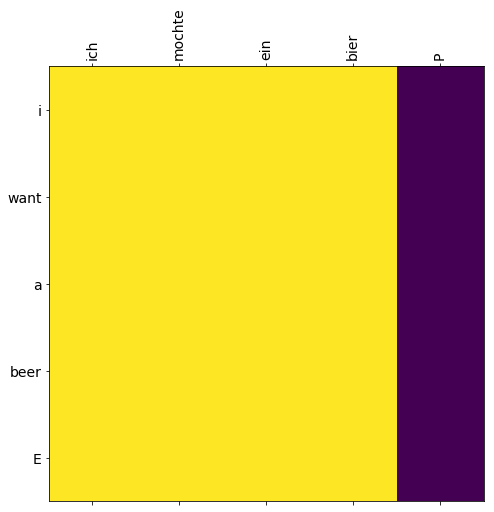

first head of last state dec_self_attns


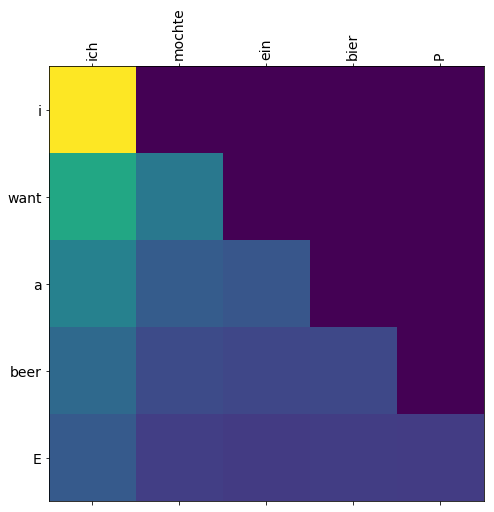

first head of last state dec_enc_attns


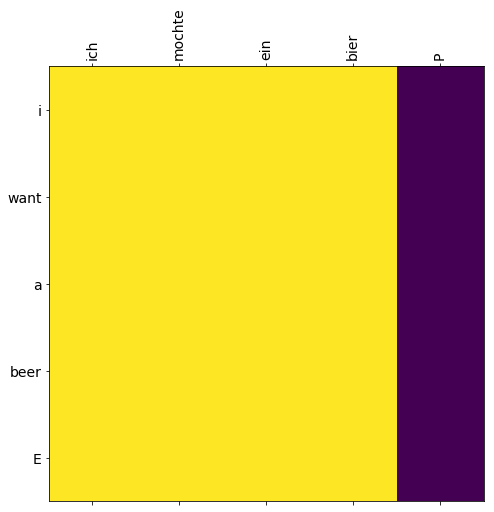

In [25]:
# Test
predict, _, _, _ = model(enc_inputs, dec_inputs)
predict = predict.data.max(1, keepdim=True)[1]
print(sentences[0], '->', [number_dict[n.item()] for n in predict.squeeze()])

print('first head of last state enc_self_attns')
showgraph(enc_self_attns)

print('first head of last state dec_self_attns')
showgraph(dec_self_attns)

print('first head of last state dec_enc_attns')
showgraph(dec_enc_attns)

In [ ]:
from tokenizers import BertWordPieceTokenizer

In [ ]:
# 내용 분석
def predict(config, tokenizer, model, text):
    if type(text) is str:
        texts = [text]
    sos = tokenizer.convert_tokens_to_ids(['[CLS]'])  # converting for start token id
    eos = tokenizer.convert_tokens_to_ids(['[SEP]'])  # converting for end token id

    enc_ids = text2ids(texts, tokenizer, config, 'encoder')
    dec_ids = torch.zeros(len(enc_ids), config.dec_max_seq_length, dtype=torch.long, device=config.device)

    next_idx = sos[0]
    for i in range(config.dec_max_seq_length):
        if next_idx == eos[0]:
            dec_ids = dec_ids[:, 1:i][0]  # delete start, end token
            break
        dec_ids[0][i] = next_idx
        output, _ = model(enc_ids, dec_ids)
        output = output.squeeze(0).max(dim=-1, keepdim=False)[1]
        next_idx = output[i].item()
    ids = dec_ids.to('cpu').numpy()
    tokens = tokenizer.convert_ids_to_tokens(ids)
    text = tokenizer.convert_tokens_to_string(tokens)
    return text
